In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import astropy
from astropy.io import fits

import pysm3
import pysm3.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

from MyUnits import *

HomeDir = '../'
DataDir = HomeDir + 'data/'

### Brightness Temperature and Specific Intensity
Units of skymap are in radio brightness (brightness temperature):
$$[B] = \text{erg}\text{ cm}^{-2}\text{ sr}^{-1}\text{ s}^{-1}\text{ Hz}^{-1}$$
The specific intensity $I_\nu$ is connected to the thermodynamic temperature by the Rayleigh-Jeans law (which is valid at low energies, or  when $h\nu \ll k_B T$):
$$I_\nu = \frac{2\nu^2 k_B T}{c^2}\Rightarrow T = \frac{I_\nu c^2}{2\nu^2 k_B} $$

In [2]:
def ray_jeans(skymap, nu):
    return (1/(2 * nu**2))*np.asarray(skymap)

def remove_b(skymap, nside, b_min):
    lon, lat = hp.pix2ang(nside, np.arange(len(skymap)), nest = False, lonlat = True)
    skymap[np.abs(lat)<b_min] = np.nan
    return skymap

Tcmb = 2.725 * Kelvin

def planckcorr():
    return 

# Test map:  408 MHz (Haslam et al.)
rms Noise (K) : 1.2

Calibration error : 10\%

Zero-levek (K) : 3

In [3]:
file = DataDir + 'haslam408_dsds_Remazeilles2014.fits'
fits.info(file)

Filename: ../data/haslam408_dsds_Remazeilles2014.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     42   3072R x 1C   [1024E]   


In [4]:
radio_map = fits.open(file)
radio_data = radio_map[1].data # assuming the first extension is a table
radio_data.shape #healpix number

(3072,)

In [5]:
radio_temps = radio_data['TEMPERATURE'].flatten() #weird format, need to flatten array

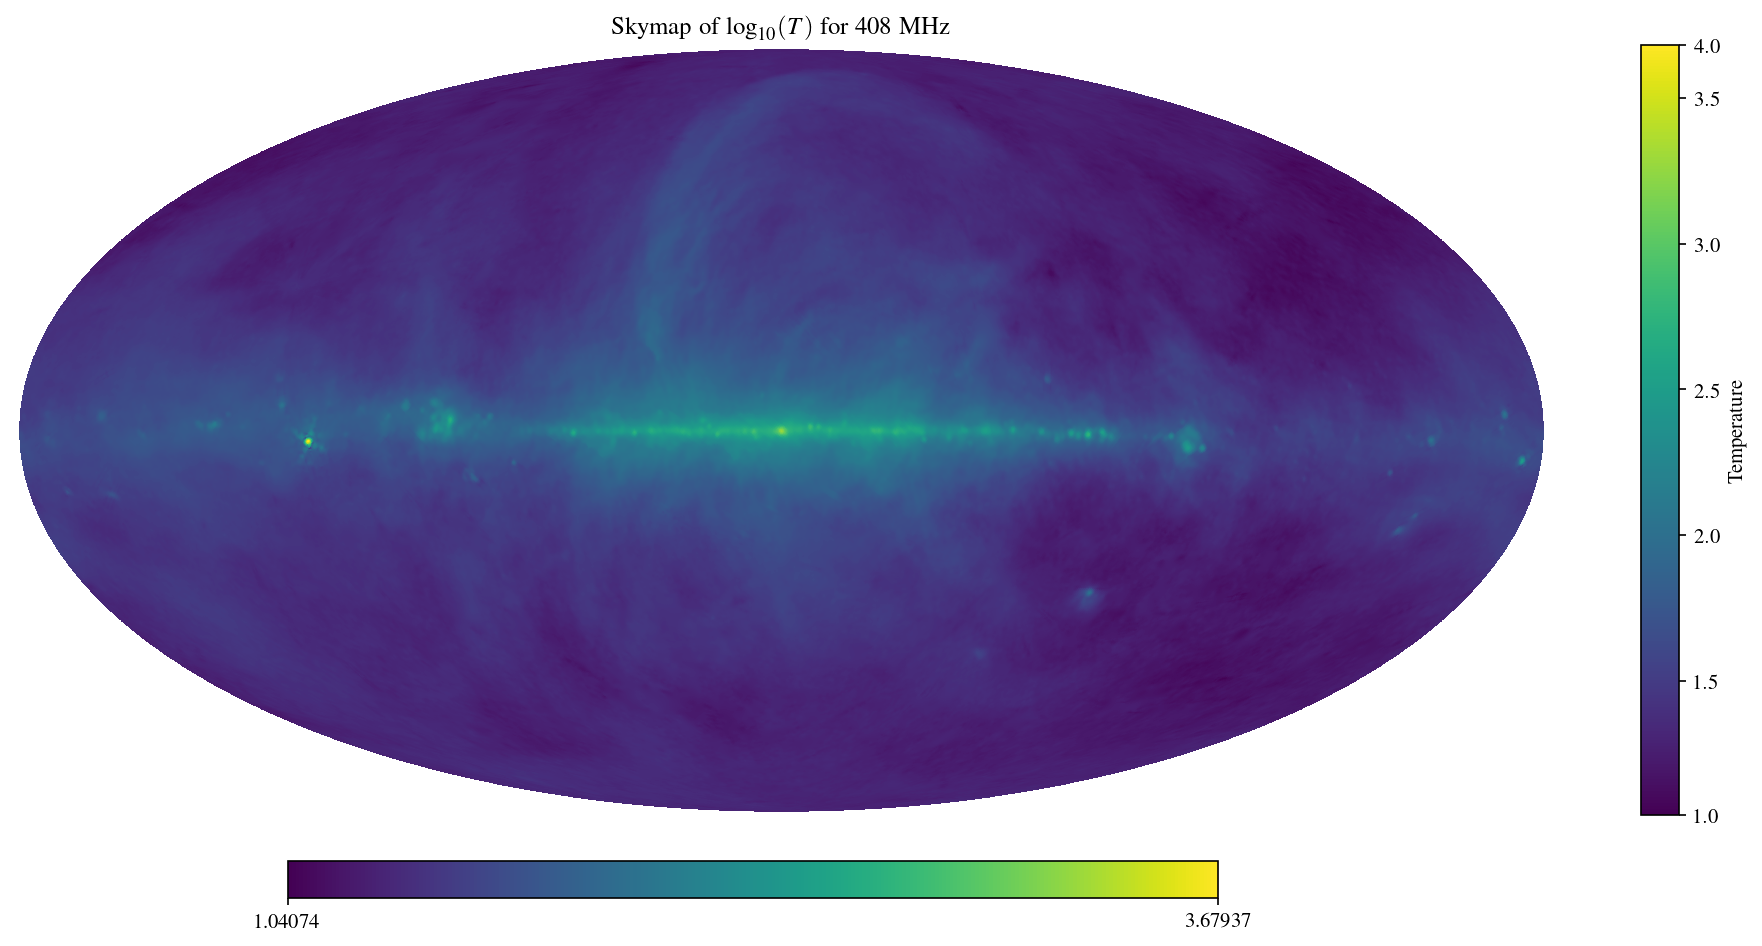

In [6]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(radio_temps)
hp.mollview(map, xsize = 6000, nest = False, hold = True, title=r"Skymap of $\log_{10}(T)$ for 408 MHz")
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'Temperature')

In [7]:
#downgrade resolution to nside = 64

radio_temps_64 = hp.pixelfunc.ud_grade(radio_temps, 64, pess=False, order_in='RING', order_out='RING', power=None, dtype=None)

In [8]:
radio_temps_64

array([18.811068, 18.609982, 18.518787, ..., 20.201176, 20.27101 ,
       20.509758], dtype=float32)

# GALPROP Map

## Fornengo et al. Parameters:

### Spatial Grids
$x = 20$ kpc, $y= 20$ kpc, $z = L$ 

Fornengo et al. consider different values of $z$, find that it has minimal effect. In this notebook, we consider $L=4$ kpc.


### Galactic CRs:
Cosmic rays accelerated to GeV energies by supernova remnants

Distribution along vertical $z$ scales $\sim \exp(|z|/z_s)$, where $z_s = 0.2$ kpc

Larger $z_s$ does not affect results, but $z_s < L$ 

Diffusion :  $D_{xx} = D_0(\rho/\rho_0)^{D_g} = 3.4 (\rho/4\text{ GV})^{0.5}$ for $L = 4$





### Magnetic field:
Fornengo et al. adopt a random magnetic field component 
$$B(R,z) = B_0 \exp [-(R-R_T)/R_B] \exp(-|z|/z_B)$$



### Electron-Positrion Flux
$$\phi_e = 4\times 10^{-10} \text{cm}^{-2}\text{sr}^{-1} \text{s}^{-1} \text{MeV}^{-1} \text{ at 34.5 GeV}$$
$$\phi_p = 4\times 5^{-9} \text{cm}^{-2}\text{sr}^{-1} \text{s}^{-1} \text{MeV}^{-1} \text{ at 100 GeV}$$

### 

## Synchrotron Radiation

### Getting the units right
Units of healpix skymap are 
$$[\text{map}] = \frac{N_\gamma}{\text{cm}^2 \, \text{s} \, \text{sr} \, \text{MeV}}$$
Convert this to specific intensity:
$$[I_\nu] = 4\pi^2 \hbar^2 \nu^2 \times \frac{N_\gamma}{\text{cm}^2 \, \text{s} \, \text{sr} \, \text{MeV}}$$
Of course, by the Rayleigh-Jeans law, we can find the brightness temperature, which is approximately equal to the thermodynamic temperature in the limit that $h\nu \ll k_B T$:
$$T \simeq \frac{I_\nu }{2\nu^2}$$

In [9]:
#conversion factor 

conv_fac = 2 * np.pi**2 * (Meter**2 * Second * Joule)/(CentiMeter**2*Second*MeV); conv_fac

1.2320270115419999e+18

In [10]:
file = DataDir + 'synchrotron_healpix_54_0bf70003.gz'
fits.info(file)

Filename: ../data/synchrotron_healpix_54_0bf70003.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SKYMAP        1 BinTableHDU     20   49152R x 1C   [14D]   
  2  ENERGIES      1 BinTableHDU     12   14R x 1C   [1D]   


In [11]:
synch = fits.open(file)
synch_data = synch[1].data # assuming the first extension is a table

labels = synch[2].data # labels of data
units = labels.names[0]

synch_data.shape #healpix number

(49152,)

In [12]:
labels

FITS_rec([(1.000e+06,), (2.000e+06,), (4.000e+06,), (8.000e+06,),
          (1.600e+07,), (3.200e+07,), (6.400e+07,), (1.280e+08,),
          (2.560e+08,), (5.120e+08,), (1.024e+09,), (2.048e+09,),
          (4.096e+09,), (8.192e+09,)],
         dtype=(numpy.record, [('Hz', '>f8')]))

In [13]:
spectra = synch_data['Spectra']

sp1 = spectra[:,0]
lab1= labels[0][0]
sp2 = spectra[:,8]
lab2= labels[8][0]

In [14]:
sp_temp = sp2*conv_fac
sp_temp

array([1.41483422, 1.41483422, 1.41483422, ..., 1.41467191, 1.41467191,
       1.41467191])

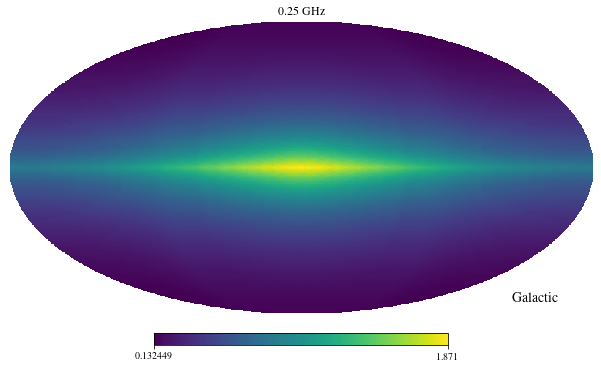

In [15]:
hp.mollview(np.log10(sp_temp), coord = ('G', 'G'), nest = False, title = r'' + str(lab2*Hz/GHz)[:4] + ' ' + 'GHz')

# Thermal Bremsstrahlung ([Finkbeiner 2003](https://arxiv.org/pdf/astro-ph/0301558.pdf))

## Read in files

In [16]:
file = DataDir + 'Halpha_fwhm06_1024.fits'
fits.info(file)

Filename: ../data/Halpha_fwhm06_1024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  H-alpha intensity    1 BinTableHDU     28   12582912R x 1C   [E]   


In [17]:
halpha = fits.open(file)
halpha_data = halpha[1].data
halpha_data

FITS_rec([( 3.5607371,), ( 3.4532976,), ( 3.5398698,), ..., (60.539658 ,),
          (41.669373 ,), (44.806786 ,)],
         dtype=(numpy.record, [('TEMPERATURE', '>f4')]))

In [18]:
halpha_temps = halpha_data['TEMPERATURE']
halpha_temps

array([ 3.5607371,  3.4532976,  3.5398698, ..., 60.539658 , 41.669373 ,
       44.806786 ], dtype=float32)

In [19]:
#downgrade resolution to Nside = 64
halpha_temps_64 = hp.pixelfunc.ud_grade(halpha_temps, 64, pess=False, order_in='NEST', order_out='NEST', power=None, dtype=None)

#re-order map from nested to ring
halpha_temps_64 = hp.reorder(halpha_temps_64, n2r=True)

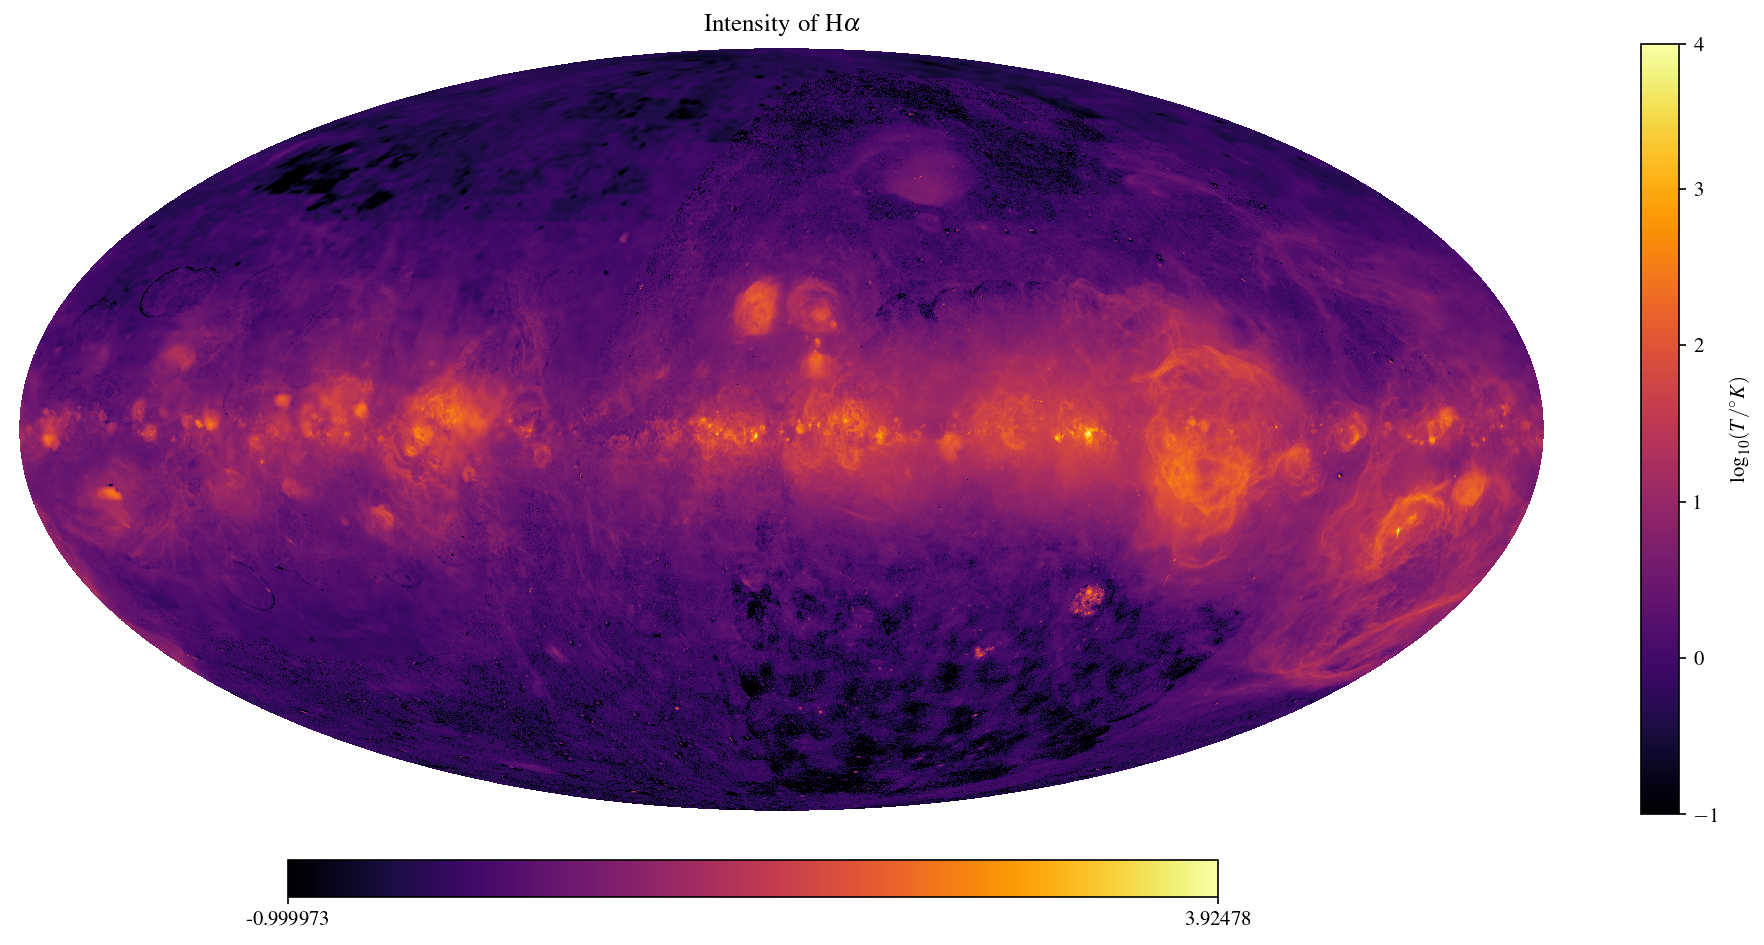

In [20]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(halpha_temps)
hp.mollview(map, xsize = 6000, nest = True, cmap = 'inferno', hold = True, title=r'Intensity of H$\alpha$')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

# PySM : Python Sky Model ([Thorne et al.](https://arxiv.org/pdf/1608.02841.pdf))

## Synchrotron only

In [21]:
freq = 408 #MHz
sky = pysm3.Sky(nside=64, preset_strings=['s1'])
emiss_map = sky.get_emission(freq * u.MHz)

In [22]:
emiss_temp_map = emiss_map[0].to(u.K_RJ).value

In [23]:
emiss_temp_map

array([ 9.047131,  9.227037, 10.22377 , ..., 10.608663, 12.010508,
       10.967336], dtype=float32)

In [24]:
sub_map = radio_temps_64 - emiss_temp_map

In [25]:
sub_map

array([9.763937, 9.382944, 8.295017, ..., 9.592513, 8.260502, 9.542422],
      dtype=float32)

In [26]:
# Mask out low-b region
nside = 64
sub_map_mask = remove_b(sub_map, nside, 10)

/tmp/ipykernel_8897/77646125.py:2: RuntimeWarning: invalid value encountered in log10
  map = np.log10(sub_map)


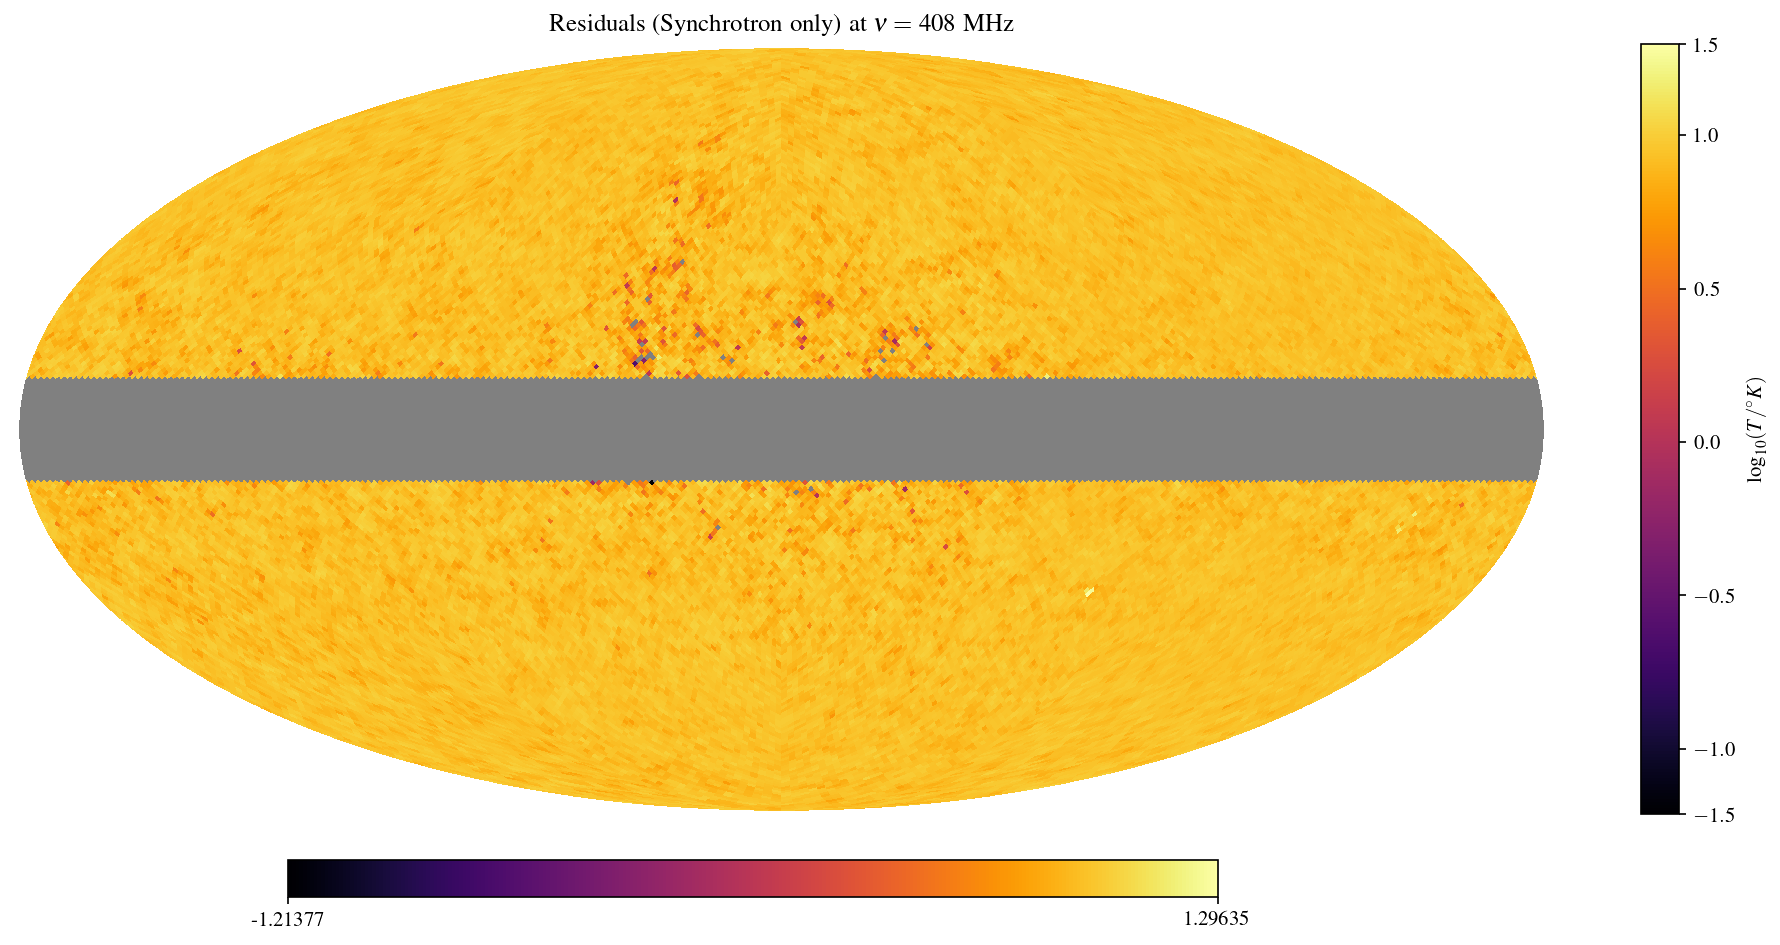

In [27]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(sub_map)
hp.mollview(map, xsize = 6000, nest = False, cmap = 'inferno', hold = True, title=r'Residuals (Synchrotron only)  at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [28]:
sub_map_good = sub_map_mask[~np.isnan(sub_map_mask)]
len(sub_map_good), np.mean(sub_map_good)

(40704, 8.556392)

# Combining models in PySM : galactic synchrotron, thermal bremsstrahlung

In [29]:
freq = 408 #MHz
sky = pysm3.Sky(nside=64, preset_strings=['f1', 's1'])
emiss_map = sky.get_emission(freq * u.MHz)

In [30]:
emiss_temp_map = emiss_map[0].to(u.K_RJ).value

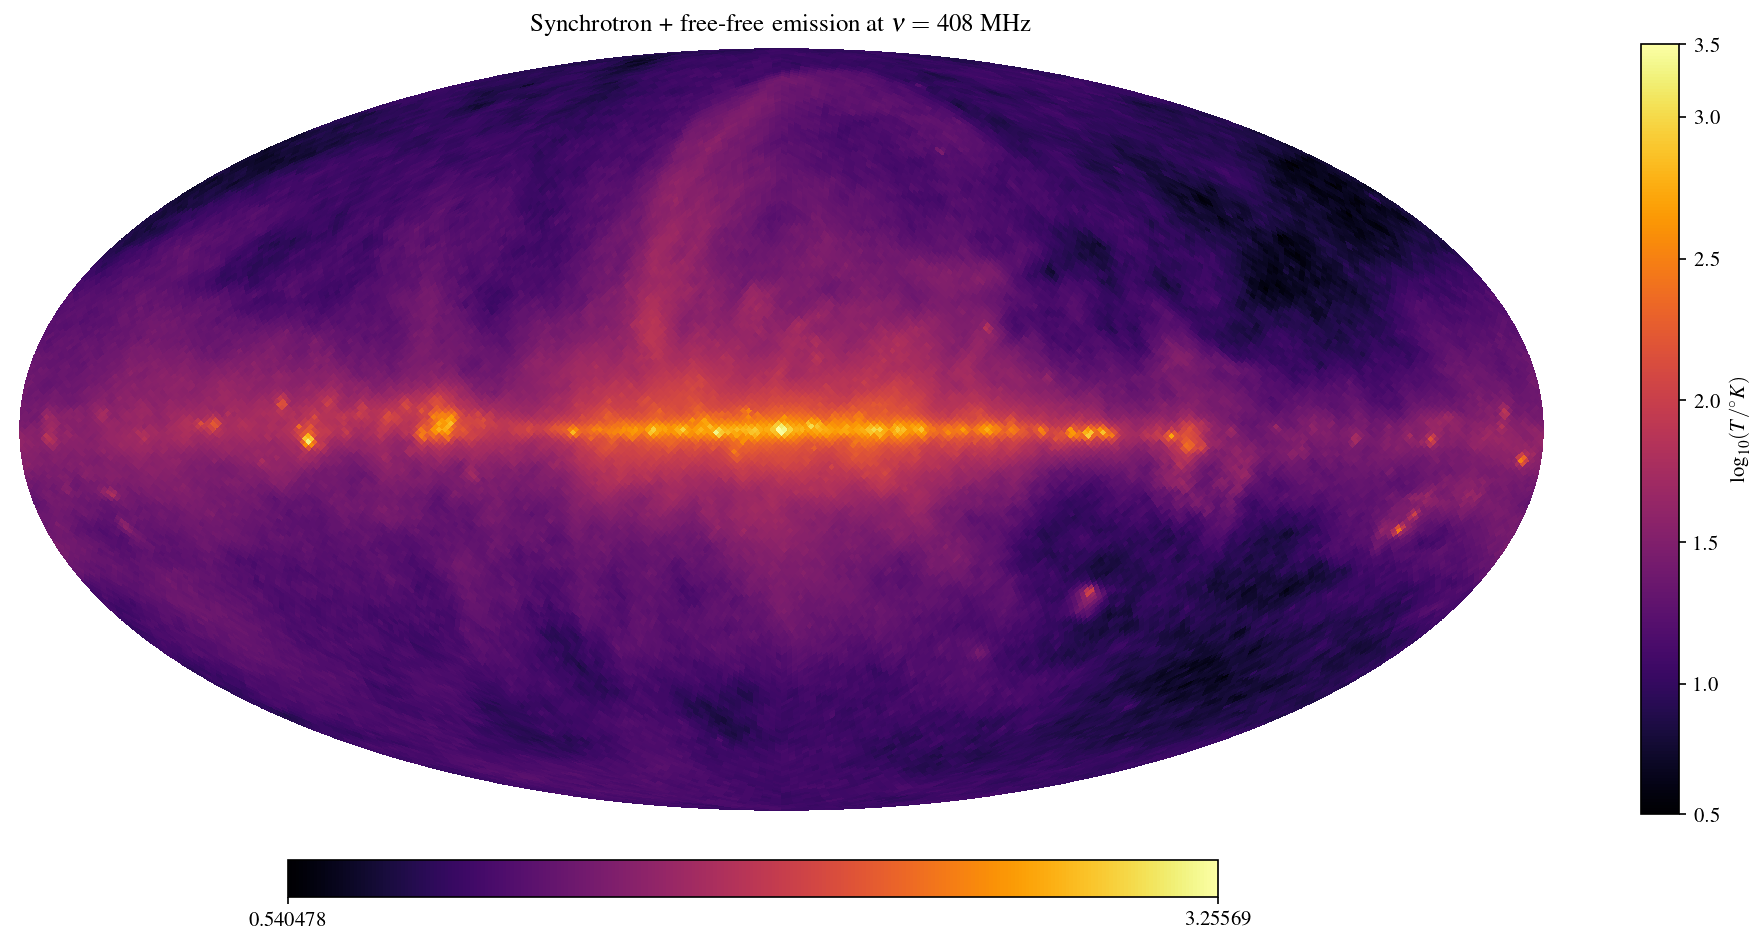

In [31]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(emiss_temp_map)
hp.mollview(map, xsize = 6000, nest = False, cmap = 'inferno', hold = True, title=r'Synchrotron + free-free emission at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

# Compute residuals after subtracting:

In [32]:
sub_map = radio_temps_64 - emiss_temp_map

In [33]:
sub_map

array([9.593329, 9.339088, 8.291047, ..., 9.592509, 8.260498, 9.507402],
      dtype=float32)

/tmp/ipykernel_8897/4088428637.py:2: RuntimeWarning: invalid value encountered in log10
  map = np.log10(sub_map)


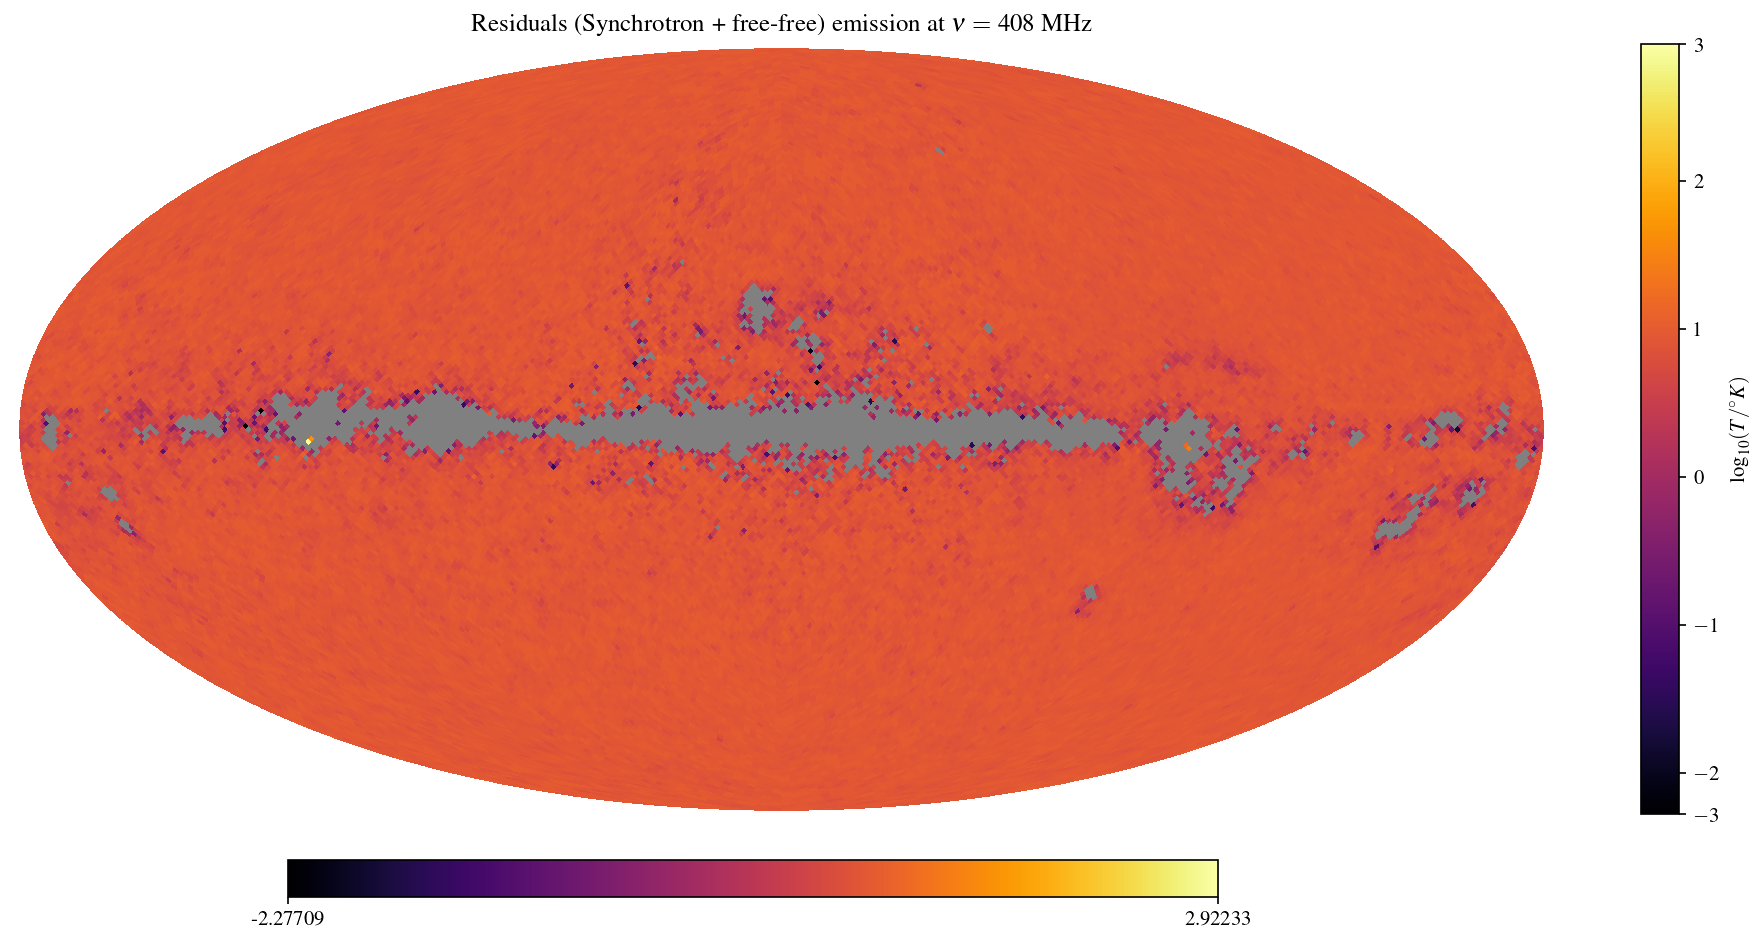

In [34]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(sub_map)
hp.mollview(map, xsize = 6000, nest = False, cmap = 'inferno', hold = True, title=r'Residuals (Synchrotron + free-free) emission at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [35]:
# Mask out low-b region
nside = 64
sub_map_mask = remove_b(sub_map, nside, 30)

In [36]:
sub_map_good = sub_map_mask[~np.isnan(sub_map_mask)]
len(sub_map_good), np.mean(sub_map_good)

(24576, 8.503854)

# Testing the validity of the $\csc|b|$ model for synchrotron radiation

In this section, we create fake data to try and see if the $\csc|b|$ model is effective in removing foreground emission sources:
$$T(\nu) = T_0(\nu) + T_G(\nu) \csc|b|$$
where
$$ T_\text{synch} \sim T_G(\nu) \csc|b|$$

We will create a mock dataset using PySM.

In [46]:
# Secret number, temperature of the isotropic excess we will try to measure
secret_number = 3.14

In [47]:
freq = 408 #MHz
sky = pysm3.Sky(nside=64, preset_strings=['s1'])
emiss_map = sky.get_emission(freq * u.MHz)
emiss_temp_map = emiss_map[0].to(u.K_RJ).value + secret_number

In [48]:
emiss_temp_map

array([12.187131 , 12.367038 , 13.3637705, ..., 13.748663 , 15.150508 ,
       14.107336 ], dtype=float32)

In [49]:
nside = 64 

# Noah's best-fit values
T_G1 = 5.22415
T_G2 = 5.20061

In [50]:
abs_b = np.abs(hp.pix2ang(nside, np.arange(len(emiss_temp_map)), nest = False, lonlat = True)[1])
abs_b = np.radians(abs_b)
csc_b_map = 1/np.sin(abs_b)

/tmp/ipykernel_8897/2602138528.py:3: RuntimeWarning: divide by zero encountered in true_divide
  csc_b_map = 1/np.sin(abs_b)


In [51]:
# Mask out low-b region
nside = 64
b_min = 10

csc_b_map = remove_b(csc_b_map, nside, b_min)
emiss_temp_map = remove_b(emiss_temp_map, nside, b_min)

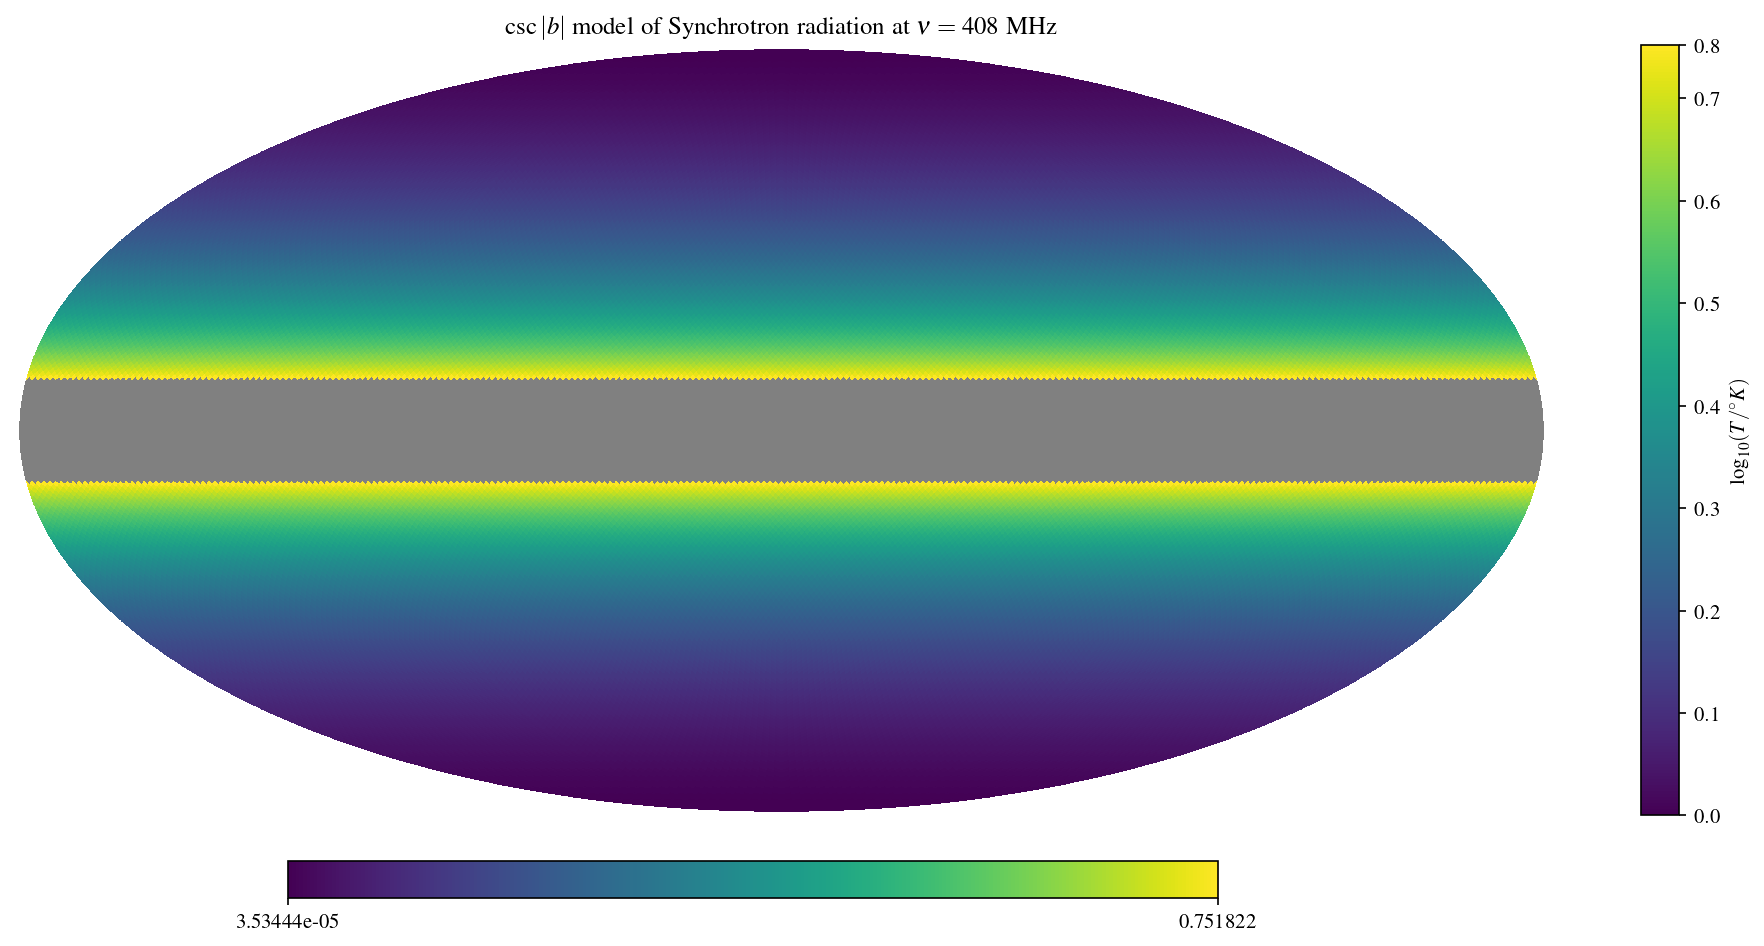

In [52]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(csc_b_map)
hp.mollview(map, xsize = 6000, nest = False, hold = True, title=r'$\csc|b|$ model of Synchrotron radiation at $\nu=$ ' + str(freq) + ' MHz')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [53]:
# Residuals from PySM model
residuals = emiss_temp_map - T_G2*csc_b_map
np.mean(residuals[~np.isnan(residuals)])

9.363988760459568

In [54]:
#Residuals from Haslam
residuals = radio_temps_64 - T_G1*csc_b_map
np.mean(residuals[~np.isnan(residuals)])

14.73032763661165